# Calculating attribution scores per ROI

In [1]:
import copy
import numpy as np 
import pandas as pd

import glob 
import matplotlib.pyplot as plt
import numpy as np 
import os 

import nibabel as nib
import json

from monai.transforms import Compose, AddChannel, Resize 
from tqdm import tqdm
%matplotlib inline


In [2]:

def extracting_score(mask_img_dir, subject_list, subject_file_list): 
    # loading mask image
    mask = nib.load(mask_img_dir) 
    mask = np.array(mask.dataobj)

    # calculating mean attribution scores per ROI 
    seg_attr_result = {}
    for i in tqdm(range(1, len(np.unique(mask)))): 
        seg_mask = np.where(mask != i, 0, 1)
        transform = Compose([AddChannel(), Resize((128, 128, 128))])
        seg_mask = transform(seg_mask)[0, :, :, :] 
        seg_subj_attr_result = []
        for subj in subject_file_list: 
            # standardizing subject's attribution score across the whole brain
            subj_img = np.load(subj)
            subj_img = (subj_img - np.mean(subj_img)) / np.std(subj_img)
            # masking ROI
            seg_subj_attr = subj_img * seg_mask
            # calculating mean attr score per ROI
            if np.sum(seg_mask) == 0: 
                seg_subj_attr_norm = 0 
            else: 
                seg_subj_attr_norm = np.sum(seg_subj_attr) / np.sum(seg_mask)
            seg_subj_attr_result.append(seg_subj_attr_norm)
        seg_attr_result["%s" % i] = seg_subj_attr_result 

    df = {'subjectkey': subject_list}
    df.update(seg_attr_result)
    return pd.DataFrame(df)


def normalizing(df:pd.DataFrame): 
    col_list = list(df.keys())[1:]
    for i in col_list: 
        arr = df[i].values
        mean = np.mean(arr)
        stdev = np.std(arr)
        df[i] = (arr - mean) / stdev
    return df 


In [100]:
### HarvardOxford
# cortical
HarvardOxford_cort_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz"
HarvardOxford_cort_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/HarvardOxford/cort_label.json"
HarvardOxford_cort_attr_save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"
# subcortical
HarvardOxford_subcort_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz"
HarvardOxford_subcort_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/HarvardOxford/subcort_label.json"
HarvardOxford_subcort_attr_save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore.csv"


### Cerebellum 
cerebellum_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/cerebellum/Cerebellum-MNIfnirt-maxprob-thr25-1mm.nii.gz"
cerebellum_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/cerebellum/cerebellum_fnirt_label.json"
cerebellum_attr_save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"


mask_img_dir = cerebellum_mask
mask_LUT_dir = cerebellum_LUT
attr_save_dir = cerebellum_attr_save_dir


In [101]:
# get every partition data
OBESITY_attr_dir = [] 
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/after1y/partition0')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/after1y/partition1')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/after1y/partition2')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/after1y/partition3')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/after1y/partition4')

# gathering the name of subject files
subject_file_list = []
subject_list = [] 
for OBESITY_attr_dir_partition in OBESITY_attr_dir:
    for file in  glob.glob(OBESITY_attr_dir_partition + '/*'): 
        subject_file_list.append(file)
        subject_list.append(os.path.split(file)[-1].replace('.npy', ''))

# calculating mean attribution score per ROI 
df = extracting_score(mask_img_dir=mask_img_dir, subject_file_list=subject_file_list, subject_list=subject_list)

# indexing ROI name based on the number of ROI 
with open(mask_LUT_dir, 'r') as file:
    LUT = json.load(file) 
df.columns = ['subjectkey'] + list(LUT.values())

  0%|          | 0/28 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
 29%|██▊       | 8/28 [02:00<04:53, 14.66s/it]/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_27685/290407655.py:20: RuntimeWarning: invalid value encountered in scalar divide
  seg_subj_attr_norm = np.sum(seg_subj_attr) / np.sum(seg_mask)
100%|██████████| 28/28 [06:52<00:00, 14.73s/it]


In [102]:
df.to_csv(attr_save_dir, index=False)

# Visualize and checking individual variability of mean attribution score per ROI

In [103]:
# filtering case subject 
pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv')
case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
df_filtered = pd.merge(df, case_subject_list, how='inner', on='subjectkey')


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6715: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6716: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

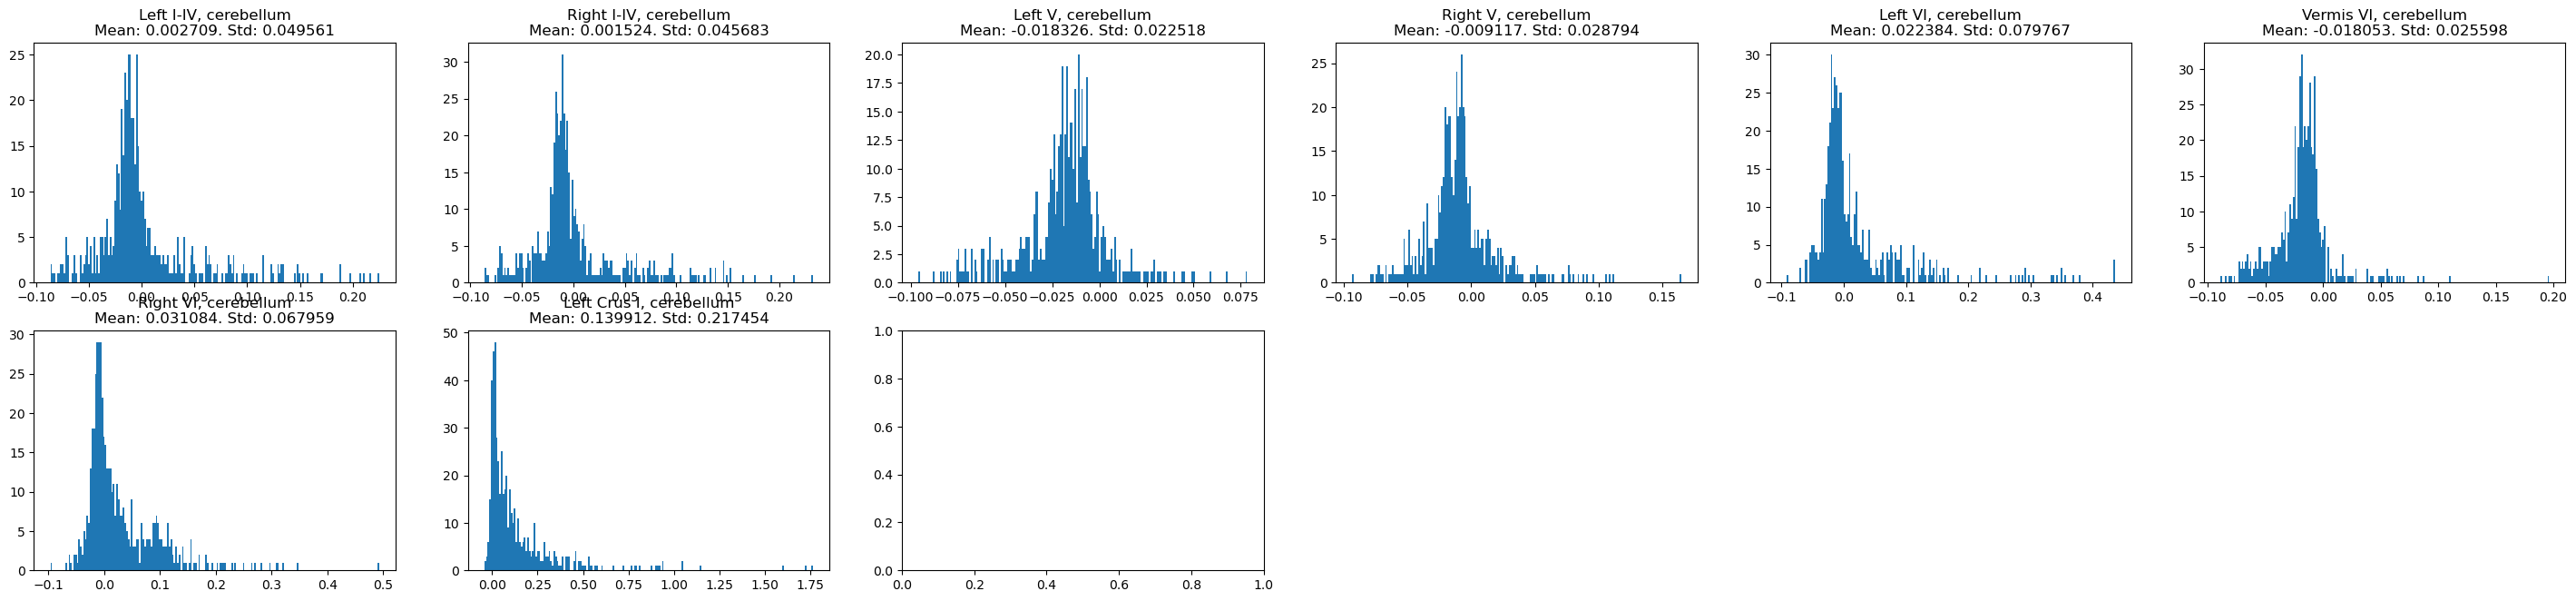

In [131]:
# plotting 
nrows = ncols = int(np.sqrt(int(len(df_filtered.keys()[:-1]))) + 1)

plt.figure(figsize=(36, 24))
for i, ROI in enumerate(df_filtered.keys()[1:]): 
    plt.subplot(nrows, ncols, i+1)
    plt.hist(df_filtered[ROI].values, bins=200)
    plt.title("{}\nMean: {:2f}. Std: {:2f}".format(ROI,np.mean(df_filtered[ROI]), np.std(df_filtered[ROI])))

plt.tight_layout()
plt.show()

    

In [128]:
new = {} 
with open(mask_LUT_dir, 'r') as file:
    LUT = json.load(file) 


In [132]:
ROI_num = 8
# loading mask image
mask = nib.load(mask_img_dir) 
mask = np.array(mask.dataobj)

# calculating mean attribution scores per ROI 
seg_attr_result = {}

seg_mask = np.where(mask != i, 0, 1)
transform = Compose([AddChannel(), Resize((128, 128, 128))])
seg_mask = transform(seg_mask)[0, :, :, :] 
seg_subj_attr_result = []
for subj in subject_file_list: 
    # standardizing subject's attribution score across the whole brain
    subj_img = np.load(subj)
    subj_img = (subj_img - np.mean(subj_img)) / np.std(subj_img)
    # masking ROI
    seg_subj_attr = subj_img * seg_mask

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


KeyboardInterrupt: 

In [173]:
i = 9
seg_mask = np.where(mask != i, 0, 1)
transform = Compose([AddChannel(), Resize((128, 128, 128))])
seg_mask = transform(seg_mask)[0, :, :, :] 
seg_subj_attr_result = []
for subj in subject_file_list: 
    # standardizing subject's attribution score across the whole brain
    subj_img = np.load(subj)
    subj_img = (subj_img - np.mean(subj_img)) / np.std(subj_img)
    # masking ROI
    seg_subj_attr = subj_img * seg_mask
    # calculating mean attr score per ROI
    if np.sum(seg_mask) == 0: 
        seg_subj_attr_norm = 0
    else:
        seg_subj_attr_norm = np.sum(seg_subj_attr) / np.sum(seg_mask)
    seg_subj_attr_result.append(seg_subj_attr_norm)
seg_subj_attr_result 

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_27685/4205132804.py:14: RuntimeWarning: invalid value encountered in scalar divide
  seg_subj_attr_norm = np.sum(seg_subj_attr) / np.sum(seg_mask)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [170]:
ROI_num = 9
mask_tmp = nib.load("/Users/wangheehwan/Desktop/CNN_for_BMI/atlas/cerebellum/Cerebellum-MNIfnirt-maxprob-thr25-1mm.nii.gz")
mask_tmp = np.array(mask_tmp.dataobj)
mask_tmp = np.where(mask_tmp == ROI_num, 1, 0)

In [171]:


from ipywidgets import interact 
def sagittal_view(x,): 
    plt.figure()
    plt.imshow(mask_tmp[x,:,:], cmap='gray')
    #plt.imshow(seg_mask[x,:,:], cmap='Reds',alpha=0.5)
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(mask_tmp[:,:,x], cmap='gray')
    #plt.imshow(seg_mask[:,:,x], cmap='Reds',alpha=0.5)
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(mask_tmp[:,x,:], cmap='gray')
    #plt.imshow(seg_mask[:,x,:], cmap='Reds',alpha=0.5)
    plt.show()

interact(sagittal_view, x=(0,181))
interact(coronal_view, x=(0,217))
interact(horizontal_view, x=(0,181))

interactive(children=(IntSlider(value=90, description='x', max=181), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=108, description='x', max=217), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=90, description='x', max=181), Output()), _dom_classes=('widget-interact…

<function __main__.horizontal_view(x)>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [172]:
np.unique(mask_tmp)

array([0, 1])